In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import warnings;warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/phase1/train_4521.csv',index_col=0)
df.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# define columns

In [0]:
x_cols = df.columns.tolist()[:4]
t_cols = df.columns.tolist()[:3]
y_cols = df.columns.tolist()[4:]
g_cols = ['C5N',
          'C6N','C6A',
          'C7N','C7A',
          'C8N','C8A',
          'C9N','C9A',
          'C10N','C10A']
h_cols =  ['C5NP','C5IP',
           'C6NP','C6IP',
           'C7NP','C7IP',
           'C8NP','C8IP',
           'C9NP','C9IP',
           'C10NP','C10IP']

# scale

In [4]:
df['raw_NA'] = df['N+A'].values
ss = StandardScaler()
df[x_cols] = ss.fit_transform(df[x_cols])
df = df[x_cols+['raw_NA']+g_cols+h_cols]
df.head()

,T10,T50,T90,N+A,raw_NA,C5N,C6N,C6A,C7N,C7A,C8N,C8A,C9N,C9A,C10N,C10A,C5NP,C5IP,C6NP,C6IP,C7NP,C7IP,C8NP,C8IP,C9NP,C9IP,C10NP,C10IP
0,0.435162,0.540969,0.471798,-1.028321,31.978,0.059,2.819,0.494,6.411,2.917,4.810,5.373,4.590,3.661,0.525,0.319,0.272,0.132,5.293,2.570,10.395,8.070,9.138,9.649,6.405,9.759,0.875,5.257
1,0.353320,0.340075,0.237602,-1.077598,31.568,0.062,2.804,0.499,6.395,2.894,4.753,5.443,4.301,2.995,1.119,0.303,0.297,0.151,5.089,2.531,10.074,7.958,8.970,9.548,6.324,9.899,0.881,5.591
2,0.389694,0.479156,0.261022,-1.104520,31.344,0.061,2.771,0.492,6.378,2.890,4.778,5.468,4.274,2.979,0.964,0.289,0.262,0.126,5.107,2.571,10.069,7.913,9.006,9.591,6.360,9.983,0.865,5.641
3,0.426068,0.448249,-0.371307,-1.091419,31.453,0.060,2.650,0.469,6.376,2.866,4.889,5.510,4.420,2.964,0.968,0.281,0.224,0.105,4.894,2.497,10.015,7.685,9.133,9.708,6.444,10.182,0.830,5.637
4,0.426068,0.370982,-0.535244,-1.002841,32.190,0.061,2.695,0.477,6.394,2.877,4.855,5.500,4.347,3.725,0.969,0.290,0.243,0.117,4.946,2.503,10.053,7.765,9.101,9.676,6.416,10.115,0.835,4.823


# split

In [5]:
from sklearn.model_selection import train_test_split

X = df[x_cols+['raw_NA']].to_numpy()
Y = df[g_cols+h_cols].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3164, 5)
(1357, 5)
(3164, 23)
(1357, 23)


# Tensor

In [0]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float)
Y_test = torch.tensor(Y_test, dtype=torch.float)

# data_iter

In [0]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

# Construct the neural network

In [0]:
class Dual_net(nn.Module):
  def __init__(self,input_shape,g_shape,h_shape):
    super(Dual_net,self).__init__()
    # common fc
    hid = 128
    self.fc1 = nn.Linear(input_shape,hid)
    self.fc2 = nn.Linear(hid,hid)
    self.fc3 = nn.Linear(hid,hid)
    # g
    self.g0 = nn.Linear(hid,hid)
    self.g1 = nn.Linear(hid,hid)
    self.g2 = nn.Linear(hid,g_shape)
    # h
    self.h0 = nn.Linear(hid,hid)
    self.h1 = nn.Linear(hid,hid)
    self.h2 = nn.Linear(hid,h_shape)
    # activation
    self.relu = nn.ReLU()
  
  def forward(self,x):
    # get raw N+A and raw other
    g_total = x[:,4].unsqueeze(1)
    h_total = 100 - x[:,4].unsqueeze(1)
    # only keep scaled_t_cols and scaled_N+A 
    x = x[:,:4]
    # common forward
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    # forward g and normalize
    #g = self.relu(self.g0(x))
    g = self.g1(x)
    g = F.softmax(self.g2(x),dim=1)*g_total
    # forward h and normalize
    #h = self.relu(self.h0(x))
    h = self.h1(x)
    h = F.softmax(self.h2(x),dim=1)*h_total
    # concat (g,h)
    y = torch.cat((g,h),1)
    return y

In [0]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform(m.weight)
    m.bias.data.fill_(0)
    print('initialize {}'.format(m))

In [10]:
net = Dual_net(4,11,12)
net.apply(init_weights)

initialize Linear(in_features=4, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=11, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=12, bias=True)


Dual_net(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (g0): Linear(in_features=128, out_features=128, bias=True)
  (g1): Linear(in_features=128, out_features=128, bias=True)
  (g2): Linear(in_features=128, out_features=11, bias=True)
  (h0): Linear(in_features=128, out_features=128, bias=True)
  (h1): Linear(in_features=128, out_features=128, bias=True)
  (h2): Linear(in_features=128, out_features=12, bias=True)
  (relu): ReLU()
)

# loss_function and optimizer

In [0]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [0]:
loss_function = RMSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)

# Training and evaluation

In [0]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
  history = []
  for epoch in range(num_epochs):
    for x,y in train_iter:
      loss = loss_function(net(x),y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # end for
    print("epochs {} loss {:.4f}".format(epoch,loss.item()))
    if loss.item() < 0.365:
      break
    history.append(loss.item())
  # end for
  plt.plot(np.array(history))
  plt.title('train loss')
  return net

epochs 0 loss 3.1587
epochs 1 loss 2.8242
epochs 2 loss 2.4605
epochs 3 loss 2.0349
epochs 4 loss 1.6717
epochs 5 loss 1.5086
epochs 6 loss 1.2516
epochs 7 loss 1.0420
epochs 8 loss 0.9355
epochs 9 loss 1.0057
epochs 10 loss 1.1523
epochs 11 loss 0.9854
epochs 12 loss 0.8071
epochs 13 loss 0.8843
epochs 14 loss 0.9616
epochs 15 loss 0.8963
epochs 16 loss 0.6922
epochs 17 loss 0.9918
epochs 18 loss 0.6196
epochs 19 loss 0.8888
epochs 20 loss 0.9319
epochs 21 loss 0.7278
epochs 22 loss 0.5839
epochs 23 loss 0.9681
epochs 24 loss 0.5814
epochs 25 loss 1.1043
epochs 26 loss 1.7068
epochs 27 loss 0.6510
epochs 28 loss 1.0642
epochs 29 loss 0.5097
epochs 30 loss 0.5484
epochs 31 loss 0.6424
epochs 32 loss 0.9262
epochs 33 loss 0.5964
epochs 34 loss 0.7206
epochs 35 loss 1.3620
epochs 36 loss 0.6538
epochs 37 loss 0.7520
epochs 38 loss 0.6034
epochs 39 loss 1.2489
epochs 40 loss 0.5282
epochs 41 loss 0.7794
epochs 42 loss 0.6823
epochs 43 loss 0.8974
epochs 44 loss 0.8682
epochs 45 loss 0.502

Dual_net(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (g0): Linear(in_features=128, out_features=128, bias=True)
  (g1): Linear(in_features=128, out_features=128, bias=True)
  (g2): Linear(in_features=128, out_features=11, bias=True)
  (h0): Linear(in_features=128, out_features=128, bias=True)
  (h1): Linear(in_features=128, out_features=128, bias=True)
  (h2): Linear(in_features=128, out_features=12, bias=True)
  (relu): ReLU()
)

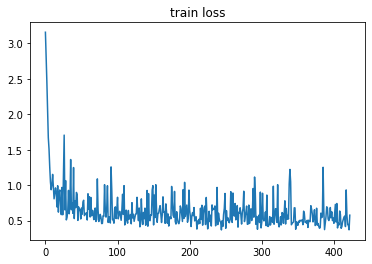

In [14]:
train(net,train_iter,loss_function,optimizer,num_epochs=1000)

# predict

In [0]:
y_pred = net(X_test).detach().numpy()
y_real = Y_test.detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=g_cols+h_cols)[y_cols]
y_real = pd.DataFrame(y_real,columns=g_cols+h_cols)[y_cols]

In [16]:
y_pred.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.461484,0.322669,0.051969,4.464067,1.957693,2.735931,0.654521,10.492964,7.919146,6.456284,2.973159,9.533070,10.126275,5.097260,5.328704,6.342155,10.071034,4.556020,3.322922,1.006869,5.096565,0.546954,0.482276
1,9.242173,6.764837,1.094550,6.442904,7.656085,6.654846,2.356804,5.604897,5.697542,10.263255,3.295980,4.546033,4.403881,5.462707,3.649579,2.603800,4.926518,2.938269,1.570851,1.012041,2.649282,0.491503,0.671656
2,0.245844,0.161725,0.032358,3.346081,1.139460,2.314285,0.537633,10.917281,8.177757,6.818314,3.022992,9.826222,10.422038,5.426436,5.678351,6.524893,10.654734,4.683532,3.377324,0.760766,5.016205,0.500544,0.415228
3,0.291603,0.199313,0.032299,3.690057,1.315148,2.327674,0.524474,10.854421,8.014260,6.483541,2.973301,9.856676,10.427977,5.161060,5.450098,6.596172,10.579491,4.562065,3.481971,0.906169,5.244709,0.528495,0.499022
4,2.328790,1.395031,0.305742,2.983939,2.803380,5.323826,0.520345,5.846519,5.897274,18.463678,3.512871,5.672984,6.552239,9.775188,4.652979,2.953038,7.190737,5.344854,2.199462,0.799945,4.105123,0.715150,0.656900


In [17]:
y_real.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.428,0.242,0.052,4.339,1.800,2.475,0.488,10.614,7.778,6.648000,3.000,9.557,10.257,5.017,5.354,6.320,9.887,4.828,3.368,0.919,5.034,0.541,0.435
1,7.850,5.467,0.780,7.012,7.951,7.060,2.426,5.701,6.196,10.217000,3.160,4.513,4.859,5.342,3.367,2.464,4.781,3.126,1.654,1.081,2.849,0.559,0.759
2,0.233,0.175,0.025,3.026,0.786,2.314,0.389,10.812,7.907,7.313000,3.213,9.748,10.480,5.221,5.787,6.614,10.756,4.250,3.384,0.735,4.688,0.585,0.326
3,0.046,0.024,0.012,3.892,1.266,2.199,0.401,10.848,7.669,6.472000,3.082,10.318,11.059,5.208,5.487,6.508,10.085,4.992,3.303,0.815,4.901,0.499,0.369
4,2.306,1.492,0.277,2.732,2.560,4.559,0.609,5.690,5.916,18.572001,3.592,5.128,6.858,9.576,4.610,2.546,7.436,5.706,2.365,0.747,4.039,0.823,0.782


In [18]:
res = pd.DataFrame(index=y_cols,columns=['R2','RMSE'])
for i in y_cols:
  res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
  res.loc[i,'RMSE'] = sqrt(mean_squared_error(y_real[i],y_pred[i]))
res.loc['AVG'] = res.mean(axis=0)
res

,R2,RMSE
C5NP,0.900445,0.696566
C5IP,0.84799,0.621633
C5N,0.587888,0.157137
C6NP,0.710956,0.660519
C6IP,0.857684,0.673481
C6N,0.816264,0.816606
C6A,0.806105,0.806646
C7NP,0.943948,0.561077
C7IP,0.871762,0.587389
C7N,0.930385,1.22368


In [19]:
temp = pd.DataFrame()
temp['real'] = y_real[g_cols].sum(axis=1).values
temp['pred'] = y_pred[g_cols].sum(axis=1).values
temp

,real,pred
0,32.206001,32.206001
1,38.450001,38.450001
2,32.807003,32.806995
3,32.024002,32.023998
4,51.471004,51.470993
...,...,...
1352,35.746998,35.747002
1353,38.218998,38.218998
1354,45.647999,45.647995
1355,56.240997,56.240997
